## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import math
from PIL import Image 
import math
import os
from os import listdir
from os.path import isfile, join
import sys
from functools import reduce
import operator
from PIL import Image as im
from scipy.ndimage import interpolation as inter
from skimage.io import imread, imshow
from skimage.filters import gaussian, threshold_otsu
from skimage.feature import canny
from skimage.transform import probabilistic_hough_line, rotate
from skimage.measure import compare_ssim as ssim
import tkinter as tk
from tkinter import simpledialog
ROOT = tk.Tk()
ROOT.withdraw()
import ctypes
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

## Loading images

In [2]:
base_image = cv2.imread(r'F:\Work\Upwork\ZZZZ - Proposal and Tests\Template OCR\IMG_20200116_134509.jpg')
top_image = cv2.imread(r'F:\Work\Upwork\ZZZZ - Proposal and Tests\Template OCR\IMG_20200116_134557_copy.jpg')
fake_top_image = cv2.imread(r'F:\Work\Upwork\ZZZZ - Proposal and Tests\Template OCR\IMG_20200120_122027.jpg')
print("Base image size is - {}".format(str(base_image.shape)))
print("Top image size is - {}".format(str(top_image.shape)))

Base image size is - (4032, 3024, 3)
Top image size is - (4032, 3024, 3)


### Deskewing function

In [3]:
def rotateImage(image, angle):
    angle = -1*angle
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def deskew(image):
    #threshold to get rid of extraneous noise
    thresh = threshold_otsu(image)
    normalize = image > thresh

    # gaussian blur
    blur = gaussian(normalize, 3)

    # canny edges in scikit-image
    edges = canny(blur)

    # hough lines
    hough_lines = probabilistic_hough_line(edges)

    # hough lines returns a list of points, in the form ((x1, y1), (x2, y2))
    # representing line segments. the first step is to calculate the slopes of
    # these lines from their paired point values
    slopes = [(y2 - y1)/(x2 - x1) if (x2-x1) else 0 for (x1,y1), (x2, y2) in hough_lines]

    # it just so happens that this slope is also y where y = tan(theta), the angle
    # in a circle by which the line is offset
    rad_angles = [np.arctan(x) for x in slopes]

    # and we change to degrees for the rotation
    deg_angles = [np.degrees(x) for x in rad_angles]

    # which of these degree values is most common?
    histo = np.histogram(deg_angles, bins=180)
    
    # correcting for 'sideways' alignments
    rotation_number = histo[1][np.argmax(histo[0])]

    if rotation_number > 45:
        rotation_number = -(90-rotation_number)
    elif rotation_number < -45:
        rotation_number = 90 - abs(rotation_number)

    return rotation_number

### Function to make image B&W, Resize and Gray

In [4]:
def color_change_resize_and_print_img(img, cmap='gray', size_y=1200):
    image_shape = img.shape
    image_x_y_ratio = image_shape[1]/image_shape[0]
    #Converting to black and white if image is colored
    if len(image_shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    rotation_angle = deskew(img)
    img = rotateImage(img, rotation_angle)
    print('Rotation angle is {}'.format(rotation_angle) + '\n')  
    
    #resizing image
    if image_shape[1] > size_y:
        img = cv2.resize(img,(round(size_y*image_x_y_ratio),size_y),interpolation=cv2.INTER_AREA)
    else:
        img = cv2.resize(img,(round(size_y*image_x_y_ratio),size_y),interpolation=cv2.INTER_LINEAR)
    
    img = cv2.GaussianBlur(img,(5,5),0)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,7,2)
    kernel = np.ones((1, 1), np.uint8)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    or_image = cv2.bitwise_or(img, closing)
    plt.imshow(img, cmap=cmap)
    return img, size_y, round(size_y*image_x_y_ratio)

Rotation angle is 0.0



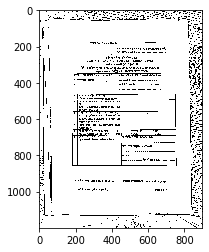

In [15]:
base_image_converted, y_base_image, x_base_image = color_change_resize_and_print_img(base_image)

Rotation angle is 0.0



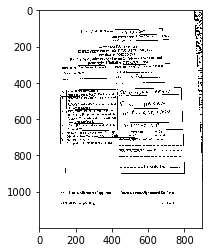

In [14]:
top_image_converted, y_top_image, x_top_image = color_change_resize_and_print_img(top_image)

Rotation angle is -43.312106995518405



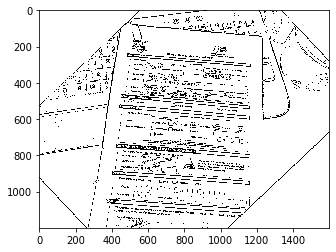

In [16]:
fake_top_image_converted, y_fake_image, x_fake_image = color_change_resize_and_print_img(fake_top_image)

In [5]:
# Create a function based on a CV2 Event (Left button click)
class image_annotation:
    def __init__(self, folder_path:str = ""):
        if folder_path == '':
            self.folder_path = sys.path[len(sys.path)-1] + "\\Data"
        else:
            self.folder_path = folder_path
        self.image_name = ""
        self.pt1 = (0,0)
        self.pt2 = (0,0)
        self.user_input = None
        self.topLeft_clicked = False
        self.botRight_clicked = False
        self.pts_list = []
        self.pts_list_final = []
        self.pts_dict = dict()
        self.annotated_df = pd.DataFrame()
        self.by_image = False
        self.key = False
        self.value = False
        
    # mouse callback function
    def draw_rectangle(self, event,x,y,flags,param):
        # get mouse click
        if event == cv2.EVENT_LBUTTONDOWN:
            if self.topLeft_clicked == True and self.botRight_clicked == True:
                self.topLeft_clicked = False
                self.botRight_clicked = False
                self.pt1 = (0,0)
                self.pt2 = (0,0)
    
            if self.topLeft_clicked == False:
                self.pt1 = (x,y)
                self.pts_list.append(self.pt1)
                self.topLeft_clicked = True
                
            elif self.botRight_clicked == False:
                self.pt2 = (x,y)
                self.pts_list.append(self.pt2)
                self.botRight_clicked = True
                if self.by_image==True and self.key==True and self.value==False:
                    ctypes.windll.user32.MessageBoxW(0, "Please draw rectangle around area containing respective value", "MLAI says", 1)
                    self.value = True
                    self.key=False
                elif self.by_image==True and self.key==False and self.value==True:
                    self.user_input = simpledialog.askstring(title="MLAI asks",  prompt="What is this key-value pair called?")
                    ctypes.windll.user32.MessageBoxW(0, "Hello, Please draw rectangle around area containing the key or press esc to exit", "MLAI says", 1)
                    self.key = True
                    self.value = False
                    self.pts_dict[self.user_input] = ""
                else:
                    pass
    
    def annotate_by_image_name(self, image_name:str = ""):
        self.pt1 = (0,0)
        self.pt2 = (0,0)
        self.topLeft_clicked = False
        self.botRight_clicked = False
        self.pts_list = []
        self.pts_list_final = []
        self.pts_dict = dict()
        self.image_name = image_name
        # Haven't drawn anything yet!        
        img = cv2.imread(os.path.join(self.folder_path, self.image_name))
        img, y_image, x_image = color_change_resize_and_print_img(img)
        img_copy = img.copy()
        # Create a named window for connections
        cv2.namedWindow(winname=self.image_name)
        # Connects the mouse button to our callback function
        cv2.setMouseCallback(self.image_name,self.draw_rectangle)
        while True: #Runs forever until we break with Esc key on keyboard
            # Shows the image window
            cv2.imshow(self.image_name,img)
            if self.topLeft_clicked:
                cv2.circle(img, center=self.pt1, radius=5, color=(0,0,255), thickness=-1)
            #drawing rectangle
            if self.topLeft_clicked and self.botRight_clicked:
                cv2.rectangle(img, self.pt1, self.pt2, (0, 0, 255), 2)
            # EXPLANATION FOR THIS LINE OF CODE:
            # https://stackoverflow.com/questions/35372700/whats-0xff-for-in-cv2-waitkey1/39201163
            #if cv2.waitKey(1) & 0xFF == ord('q'):
            k = cv2.waitKey(1)
            if k == 27 or k == ord('s') or k == ord('q') or k == ord('z') or k == ord('w') or k == ord('a'):
                break
        # Once script is done, its usually good practice to call this line
        # It closes all windows (just in case you have multiple windows called)
        cv2.destroyAllWindows()
        for i in range(0,len(self.pts_list),2):
            try:
                self.pts_list_final.append([self.pts_list[i], self.pts_list[i+1]])
            except:
                continue
        return img_copy, self.pts_list_final
    
    
    def annotate_by_image(self, image, image_save_name="Image"):
        self.pt1 = (0,0)
        self.pt2 = (0,0)
        self.topLeft_clicked = False
        self.botRight_clicked = False
        self.pts_list = []
        self.pts_list_final = []
        self.pts_dict = dict()
        self.image_name = image_save_name
        self.img = image.copy()
        self.Input_dict = dict()
        # Haven't drawn anything yet!        
        # Create a named window for connections
        cv2.namedWindow(winname=self.image_name)
        # Connects the mouse button to our callback function
        cv2.setMouseCallback(self.image_name,self.draw_rectangle)
        self.by_image=True
        ctypes.windll.user32.MessageBoxW(0, "Please draw rectangle around area containing the key", "MLAI says", 1)
        self.key = True
        #messagebox.showinfo("Hello", "Please draw rectangle around area containing the key")
        
        
        while True: #Runs forever until we break with Esc key on keyboard
            # Shows the image window
            cv2.imshow(self.image_name, self.img)
            if self.topLeft_clicked:
                cv2.circle(self.img, center=self.pt1, radius=5, color=(0,0,255), thickness=-2)
            #drawing rectangle
            if self.topLeft_clicked and self.botRight_clicked:
                if not self.pt2 == (0,0):
                    cv2.rectangle(self.img, self.pt1, self.pt2, (0, 0, 255), 1)
            # EXPLANATION FOR THIS LINE OF CODE:
            # https://stackoverflow.com/questions/35372700/whats-0xff-for-in-cv2-waitkey1/39201163
            #if cv2.waitKey(1) & 0xFF == ord('q'):
            k = cv2.waitKey(1)
            if k == 27 or k == ord('s') or k == ord('q') or k == ord('z') or k == ord('w') or k == ord('a'):
                break
        # Once script is done, its usually good practice to call this line
        # It closes all windows (just in case you have multiple windows called)
        cv2.destroyAllWindows()
        for i in range(0,len(self.pts_list),2):
            try:
                self.pts_list_final.append([self.pts_list[i], self.pts_list[i+1]])
            except:
                continue
            
        return self.pts_list_final, self.pts_dict

In [6]:
img_annotate = image_annotation(folder_path=r'F:\Work\Upwork\ZZZZ - Proposal and Tests\Template OCR')

### User to input template features for template matching exercise (all constant features)

Rotation angle is 0.0



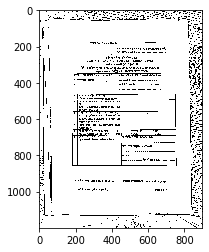

In [7]:
new_image, saved_annotations = img_annotate.annotate_by_image_name('IMG_20200116_134509.jpg')

### Getting Key-Value Pairs Inputs for first time

In [9]:
#Key-Value pair annotation
key_value_saved_annotations, points_dict = img_annotate.annotate_by_image(image=new_image)

In [10]:
i = 0
for key in list(points_dict.keys()):
    points_dict[key] = [key_value_saved_annotations[i], key_value_saved_annotations[i+1]]
    i = i+2

In [11]:
points_dict

{'Name': [[(185, 461), (450, 493)], [(452, 464), (750, 492)]],
 'Address': [[(184, 688), (449, 851)], [(454, 686), (751, 854)]]}

# Below function is no longer being used

def template_match(image_to_match, base_image, method = cv2.TM_CCORR):
    height, width = image_to_match.shape
    result = cv2.matchTemplate(image_to_match, base_image, method)
    # We want the minimum squared difference
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc    
    else:
        top_left = max_loc
        
    # Assign the Bottom Right of the rectangle
    bottom_right = (top_left[0] + width, top_left[1] + height)
    
    # Draw the Red Rectangle
    rect_image_top_matched = cv2.cvtColor(base_image, cv2.COLOR_GRAY2RGB)
    rect_image_top_matched = cv2.rectangle(rect_image_top_matched,top_left, bottom_right, 255, 10)
    return rect_image_top_matched, (top_left, bottom_right), None, None

In [12]:
def template_match(image_to_match, base_image, method = cv2.TM_CCORR, scale_invariant=False):
    height, width = base_image.shape
    max_coff = (0,0,(0,0),(0,0))
    best_height = 0
    best_width = 0
    best_scale_y = 0
    best_scale_x = 0
    best_resized_image = None
    if scale_invariant:
        for scale in np.linspace(0.5, 1.5, 15)[::-1]:
            new_height = round(height*scale)
            for scale_y in np.linspace(0.5, 1.5, 15)[::-1]:
                new_width = round(width*scale_y)
                try:
                    base_image_resized = cv2.resize(base_image, (int(new_height),int(new_width)), interpolation=cv2.INTER_LINEAR)
                    print("Reshaped from {} to {}".format(str(base_image.shape), str(base_image_resized.shape)))
                    result = cv2.matchTemplate(image_to_match, base_image_resized, method)
                    # We want the minimum squared difference
                    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
                    if max_val > max_coff[1]:
                        print("Max Coff is : {}".format(str(max_coff[1])))
                        max_coff = (min_val, max_val, min_loc, max_loc)
                        best_scale_y = scale_y
                        best_scale_x = scale
                        best_resized_image = base_image_resized.copy()
                except:
                    print("Error with new_height {}, new_width {}".format(str(new_height), str(new_width)))
                    continue
    else:
        result = cv2.matchTemplate(image_to_match, base_image, method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        best_scale_y = None
        best_scale_x = None
        best_resized_image = base_image.copy()
        max_coff = (min_val, max_val, min_loc, max_loc)   

    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = max_coff[2]
    else:
        top_left = max_coff[3]
    
    best_height = image_to_match.shape[0]
    best_width = image_to_match.shape[1]
    bottom_right = (int(top_left[0] + best_width), int(top_left[1] + best_height))
    return best_resized_image, (top_left, bottom_right), best_scale_y, best_scale_x

In [18]:
matched_cordinates_list = []
Top_left_bottom_right_cordinates_list = []
for i, annotation in enumerate(saved_annotations):
    print("Working on annotaion {}".format(str(i)))
    image_zone = new_image[annotation[0][1]:annotation[1][1], annotation[0][0]:annotation[1][0]]
    if i == 0:
        matched_image, match_cordinates, best_scale_y, best_scale_x = template_match(image_zone, top_image_converted, method=cv2.TM_CCOEFF_NORMED, scale_invariant=True)
        matched_cordinates_list.append(match_cordinates)
        Top_left_bottom_right_cordinates_list.append(match_cordinates)
    else:
        matched_image, match_cordinates, best_scale_y, best_scale_x = template_match(image_zone, matched_image, method=cv2.TM_CCOEFF_NORMED, scale_invariant=False)
        matched_cordinates_list.append(match_cordinates)
        Top_left_bottom_right_cordinates_list.append(match_cordinates)

Working on annotaion 0
Reshaped from (1200, 900) to (1350, 1800)
Max Coff is : 0
Reshaped from (1200, 900) to (1286, 1800)
Max Coff is : 0.17451635003089905
Reshaped from (1200, 900) to (1221, 1800)
Max Coff is : 0.18184633553028107
Reshaped from (1200, 900) to (1157, 1800)
Max Coff is : 0.18903198838233948
Reshaped from (1200, 900) to (1093, 1800)
Max Coff is : 0.1892053484916687
Reshaped from (1200, 900) to (1029, 1800)
Reshaped from (1200, 900) to (964, 1800)
Reshaped from (1200, 900) to (900, 1800)
Reshaped from (1200, 900) to (836, 1800)
Reshaped from (1200, 900) to (771, 1800)
Reshaped from (1200, 900) to (707, 1800)
Reshaped from (1200, 900) to (643, 1800)
Reshaped from (1200, 900) to (579, 1800)
Reshaped from (1200, 900) to (514, 1800)
Reshaped from (1200, 900) to (450, 1800)
Reshaped from (1200, 900) to (1350, 1714)
Reshaped from (1200, 900) to (1286, 1714)
Reshaped from (1200, 900) to (1221, 1714)
Reshaped from (1200, 900) to (1157, 1714)
Reshaped from (1200, 900) to (1093, 1

Reshaped from (1200, 900) to (836, 771)
Reshaped from (1200, 900) to (771, 771)
Reshaped from (1200, 900) to (707, 771)
Reshaped from (1200, 900) to (643, 771)
Reshaped from (1200, 900) to (579, 771)
Reshaped from (1200, 900) to (514, 771)
Reshaped from (1200, 900) to (450, 771)
Reshaped from (1200, 900) to (1350, 686)
Reshaped from (1200, 900) to (1286, 686)
Reshaped from (1200, 900) to (1221, 686)
Reshaped from (1200, 900) to (1157, 686)
Reshaped from (1200, 900) to (1093, 686)
Reshaped from (1200, 900) to (1029, 686)
Reshaped from (1200, 900) to (964, 686)
Reshaped from (1200, 900) to (900, 686)
Reshaped from (1200, 900) to (836, 686)
Reshaped from (1200, 900) to (771, 686)
Reshaped from (1200, 900) to (707, 686)
Reshaped from (1200, 900) to (643, 686)
Reshaped from (1200, 900) to (579, 686)
Reshaped from (1200, 900) to (514, 686)
Reshaped from (1200, 900) to (450, 686)
Reshaped from (1200, 900) to (1350, 600)
Reshaped from (1200, 900) to (1286, 600)
Reshaped from (1200, 900) to (12

In [25]:
rect_image_top_matched_temp = cv2.cvtColor(matched_image, cv2.COLOR_GRAY2RGB)
rect_image_top_matched = rect_image_top_matched_temp.copy()
for i in range(len(Top_left_bottom_right_cordinates_list)):
    rect_image_top_matched = cv2.rectangle(rect_image_top_matched, Top_left_bottom_right_cordinates_list[i][0], Top_left_bottom_right_cordinates_list[i][1], (0,255,0), 5)

True

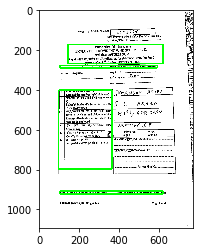

In [26]:
plt.imshow(rect_image_top_matched)
cv2.imwrite('image.jpg', rect_image_top_matched)

### Get a similarity score between labelled static form data to see if both forms are same or not

In [27]:
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    # return the MSE, the lower the error, the more "similar" the two images are
    return err
 
def compare_images(imageA, imageB):
    # compute the mean squared error and structural similarity index for the images
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB)
    return m, s

In [28]:
sse_arr = np.zeros((1, len(saved_annotations)))
for i, annotation in enumerate(saved_annotations):
    image_zone = new_image[annotation[0][1]:annotation[1][1], annotation[0][0]:annotation[1][0]]
    comapison_image_zone = matched_image[Top_left_bottom_right_cordinates_list[i][0][1]:Top_left_bottom_right_cordinates_list[i][1][1], Top_left_bottom_right_cordinates_list[i][0][0]:Top_left_bottom_right_cordinates_list[i][1][0]]
    m, s = compare_images(image_zone, comapison_image_zone)
    sse_arr[0][i] = s
    print("RMS is {} and SSE is {}".format(str(m), str(s)))
if sse_arr.mean() < 0.5 and len(np.where(sse_arr > .5)) == 0:
    print("Input form does not match the base template. Please verify the image or load a clearer image.")

RMS is 6940.8527604726105 and SSE is 0.6164745860279678
RMS is 17583.819130732376 and SSE is 0.3127457485638389
RMS is 11383.668859649122 and SSE is 0.479934529564617
RMS is 15546.59407979408 and SSE is 0.30556820956582903


C:\Users\suman\Anaconda3\envs\spyder\lib\site-packages\ipykernel_launcher.py:12: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  if sys.path[0] == '':


### Extracting values from OCR

In [29]:
for key in list(points_dict.keys()):
    print(points_dict[key])

[[(185, 461), (450, 493)], [(452, 464), (750, 492)]]
[[(184, 688), (449, 851)], [(454, 686), (751, 854)]]


In [67]:
rect_image_top_matched_temp_bw = cv2.cvtColor(rect_image_top_matched_temp, cv2.COLOR_BGR2GRAY)

In [109]:
key_val_Top_left_bottom_right_cordinates_list = []
for i, key in enumerate(list(points_dict.keys())):
    print(key)
    print("Working on annotaion {}".format(str(i)))
    image_zone = new_image[points_dict[key][0][0][1]:points_dict[key][0][1][1], points_dict[key][0][0][0]:points_dict[key][0][1][0]]
    Key_val_matched_image, Key_val_match_cordinates, best_scale_y, best_scale_x = template_match(image_zone, rect_image_top_matched_temp_bw, method=cv2.TM_CCOEFF_NORMED, scale_invariant=False)
    key_val_Top_left_bottom_right_cordinates_list.append(Key_val_match_cordinates)

Name
Working on annotaion 0
Address
Working on annotaion 1


In [69]:
#key_val_rect_image_top_matched = cv2.cvtColor(Key_val_matched_image, cv2.COLOR_GRAY2RGB)
for i in range(len(key_val_Top_left_bottom_right_cordinates_list)):
    key_val_rect_image_top_matched = cv2.rectangle(rect_image_top_matched_temp_bw, key_val_Top_left_bottom_right_cordinates_list[i][0], key_val_Top_left_bottom_right_cordinates_list[i][1], (0,255,0), 5)

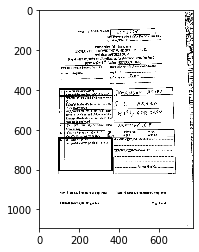

In [70]:
plt.imshow(key_val_rect_image_top_matched, cmap='gray')

In [48]:
plt.imsave('area_found.jpg', key_val_rect_image_top_matched)

In [49]:
rect_image_top_matched_temp_bw[key_val_Top_left_bottom_right_cordinates_list[0][0]]

(101, 396)

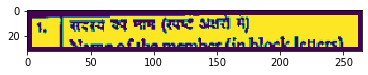

In [53]:
plt.imshow(rect_image_top_matched_temp_bw[key_val_Top_left_bottom_right_cordinates_list[0][0][1]:key_val_Top_left_bottom_right_cordinates_list[0][1][1], key_val_Top_left_bottom_right_cordinates_list[0][0][0]:key_val_Top_left_bottom_right_cordinates_list[0][1][0]]) 

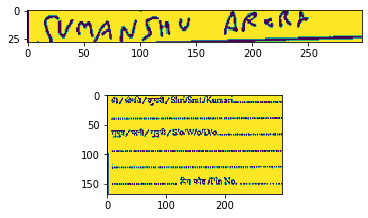

In [139]:
image_in_question_key_cordinates = []

iamge_text_dict = dict()
for i, pts in enumerate(list(points_dict.keys())):
    attribute_bot_rt = points_dict[pts][0][1]
    key_top_left = points_dict[pts][1][0]
    key_atr_width_dist = key_top_left[0] - attribute_bot_rt[0]
    key_atr_height_dist = key_top_left[1] - attribute_bot_rt[1]
    key_width = points_dict[pts][1][1][0] - points_dict[pts][1][0][0]
    key_height = points_dict[pts][1][1][1] - points_dict[pts][1][0][1]
    matched_attr_bot_rt = key_val_Top_left_bottom_right_cordinates_list[i][1]
    matched_key_top_left = (matched_attr_bot_rt[0]+key_atr_width_dist, matched_attr_bot_rt[1]+key_atr_height_dist)
    matched_key_bot_right = (matched_key_top_left[0]+key_width, matched_key_top_left[1]+key_height)
    matched_key_area_of_interest = rect_image_top_matched_temp_bw[matched_key_top_left[1]:matched_key_bot_right[1],matched_key_top_left[0]:matched_key_bot_right[0]]
    plt.subplot(len(list(points_dict.keys())), 1, i+1)
    plt.imshow(matched_key_area_of_interest)
    img_data = pytesseract.image_to_string(matched_key_area_of_interest)
    iamge_text_dict[pts] = img_data
    image_in_question_key_cordinates.append([matched_key_top_left, matched_key_bot_right])

# ----- DANGER----- RESEARCH ONLY-----

In [ ]:
cv2.KAZE()

In [ ]:
akaze = cv2.AKAZE_create()
kpts1, desc1 = akaze.detectAndCompute(fake_top_image_converted, None)
kpts2, desc2 = akaze.detectAndCompute(base_image_converted, None)

In [ ]:
image = cv2.drawKeypoints(base_image_converted, kpts2, fake_top_image_converted, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

In [ ]:
plt.imshow(image, cmap='gray')
plt.imsave('temp_image', image)

In [ ]:
matcher = cv2.BFMatcher()
nn_matches = matcher.knnMatch(desc1, desc2, 2)

In [ ]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(desc1,desc2,k=2)

In [ ]:
matched1 = []
matched2 = []
nn_match_ratio = 0.8 # Nearest neighbor matching ratio
good_matches = []
for m, n in nn_matches:
    if m.distance < nn_match_ratio * n.distance:
        matched1.append(kpts1[m.queryIdx])
        matched2.append(kpts2[m.trainIdx])
        good_matches.append([m])

In [ ]:
KAZE_matches = cv2.drawMatchesKnn(fake_top_image_converted,kpts1,base_image_converted,kpts2,good_matches,None,flags=2)

In [ ]:
def display(img,cmap='gray'):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap='gray')

In [ ]:
display(KAZE_matches)